In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,classification_report, roc_curve, log_loss, brier_score_loss, roc_auc_score, make_scorer
from timeit import default_timer as timer

pd.set_option('display.max_columns', 25)

In [2]:
#Cross Validation Function

#IS THIS NEEDED???

def CrossVal(model, X_train, y_train, scoring = None, folds = 5, test_size = 0.2):

    start_cross_val = timer()

    scores = cross_val_score(model, X_train, y_train, scoring = scoring, n_jobs = 11, cv = StratifiedShuffleSplit(n_splits = folds, test_size = test_size))
    
    print('Mean Score:',scores.mean())
    print('Score Standard Deviation',scores.std())
    print('Scores:', scores)

    end_cross_val = timer()
    print('Cross Validation Time:', round(end_cross_val - start_cross_val,1), 'seconds')
    
    return scores

In [3]:
# Custom loss function - Binned Sum of Squared Residuals

def binned_sum_of_squared_residuals(y_actual, y_predicted):

    df = pd.DataFrame(y_actual.copy())
    df.columns = ['Actual']
    df['Predicted Probability'] = y_predicted

    bins = np.arange(0,1.05,0.05)
    labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
              '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
    df['Bin'] = pd.cut(df['Predicted Probability'], bins = bins, labels = labels)
    bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()
    bin_df.reset_index(inplace = True)
    bin_df.columns = ['Bin', 'Actual', 'Predicted']

    binned_sum_of_squares = sum(((bin_df.Actual - bin_df.Predicted).fillna(0)*100) ** 2)
    
    return binned_sum_of_squares

# wrapper for grid search object
bssr = make_scorer(binned_sum_of_squared_residuals, 
                   greater_is_better = False,
                   needs_proba = True)

In [5]:
# Preprocessing Function

def preprocess(X_categorical, X_numerical, y):

    start_preprocessing = timer()

    #Create dummy columns for categorical features
    X = pd.get_dummies(X_categorical, drop_first = True)

    #Add numerical features to model dataframe
    X = pd.concat([X, X_numerical], axis = 1)

    #Scale features
    X = pd.DataFrame(StandardScaler().fit_transform(X), index = X.index, columns = X.columns)

    #Create validation test set to reserve for final validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 33)

    end_preprocessing = timer()
    print('Preprocessing Time:', round(end_preprocessing - start_preprocessing,1), 'seconds')
    
    return X_train, X_test, y_train.astype('int'), y_test.astype('int')

In [6]:
# Training Function

def train(model, X_train, y_train):
    
    start_training = timer()

    model.fit(X_train, np.ravel(y_train))

    end_training = timer()
    print('Training Time:', round(end_training - start_training,1), 'seconds')

In [7]:
# Prediction Function

def predict(model, X_validation):
    
    start_prediction = timer()

    y_pred = pd.DataFrame(model.predict(X_validation), index = X_validation.index)
    y_pred_prob = pd.DataFrame(model.predict_proba(X_validation)[:,1], index = X_validation.index)

    end_prediction = timer()
    print('Prediction Time:', round(end_prediction - start_prediction,1), 'seconds')
    
    return y_pred, y_pred_prob

In [8]:
# Reporting Function

def reports(model, X_columns, y_validation, y_pred, y_pred_prob):

    start_reports = timer()

    print('Confusion Matrix:\n', confusion_matrix(y_validation, y_pred))
    print('Classification Report:\n', classification_report(y_validation, y_pred))
    print('Accuracy:', round((sum(y_pred.iloc[:,0] == y_validation.iloc[:,0]) / len(y_pred.values) * 100),2), "%")
    print('Log Loss:', log_loss(y_validation, y_pred_prob))
    print('Brier Score Loss:', brier_score_loss(y_validation, y_pred_prob))

    fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    print('ROC AUC Score:', roc_auc_score(y_validation, y_pred_prob))
    
    if isinstance(model, RandomForestClassifier):
    
        forest_feature_importance = pd.DataFrame(zip(X_columns,model.feature_importances_))
        forest_feature_importance.sort_values(1, inplace = True)
        forest_feature_importance.reset_index(inplace = True, drop = True)

        plt.bar(forest_feature_importance[0][-20:],forest_feature_importance[1][-20:])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Largest Importances')
        plt.show()

        plt.bar(forest_feature_importance[0][0:20],forest_feature_importance[1][0:20])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Smallest Importances')
        plt.show()
        
    else:
        
        feature_coef = pd.DataFrame(zip(X_columns,model.coef_[0]))
        feature_coef.sort_values(1, inplace = True)
        feature_coef.reset_index(inplace = True, drop = True)

        plt.bar(feature_coef[0][-20:],feature_coef[1][-20:])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Largest Feature Coefficients')
        plt.show()

        plt.bar(feature_coef[0][0:20],feature_coef[1][0:20])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Smallest Feature Coefficients')
        plt.show()

    proba_df = y_validation.copy()
    proba_df['Predicted Probability'] = y_pred_prob

    #The below bins by Predicted Probability
    bins = np.arange(0,1.05,0.05)
    labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
              '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
    proba_df['Bin'] = pd.cut(proba_df['Predicted Probability'], bins = bins, labels = labels)
    #proba_df.reset_index(drop = True, inplace = True)
    chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()
    chart_df['Count'] = proba_df.groupby('Bin')['Solved'].count()
    chart_df.reset_index(inplace = True)
    chart_df.columns = ['Bin', 'Actual', 'Predicted', 'Count']

    print(chart_df)

    plt.bar(chart_df.Bin, chart_df.Count)
    plt.xticks(rotation = 45)
    plt.title('Frequency of Test Cases by Predicted Clearance Probability')
    plt.xlabel('Case Clearance Probability')
    plt.ylabel('Number of Cases')
    plt.show()

    plt.scatter(chart_df.Bin, chart_df.Actual, label = 'Actual', alpha = 1)
    plt.scatter(chart_df.Bin, chart_df.Predicted, color = 'r', marker = 'D', label = 'Predicted', alpha = 0.75)
    plt.legend()
    plt.title('Actual and Predicted Clearance Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Clearance Rate')
    plt.show()

    plt.scatter(chart_df.Predicted, chart_df.Actual)
    plt.plot([0,1],[0,1], linestyle = '--', color = 'g')
    plt.title('Actual vs. Predicted Clearance Rate by 5% bin')
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],rotation = 45)
    plt.xlabel('Predicted')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Actual')
    plt.show()

    plt.bar(chart_df.Bin, chart_df.Actual - chart_df.Predicted,)
    plt.title('Actual - Predicted Clearance Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin (Range = Value - 5% to Value)')
    #plt.yticks([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])
    plt.ylabel('Delta Clearance Rate')
    plt.show()

    print('Sum of Squared Binned Residuals:', binned_sum_of_squared_residuals(y_validation, y_pred_prob))

    end_reports = timer()
    print('Reporting Time:', round(end_reports - start_reports,1), 'seconds')
    
    return proba_df, chart_df

In [9]:
# Load data into DataFrame
murders_df = pd.read_csv('C:\\Users\\Work_Remote\\Desktop\\murders_cleaned.csv')

In [10]:
murders_df.columns

Index(['Agentype', 'Solved', 'Year', 'Month', 'Homicide', 'Situation',
       'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon', 'VicCount',
       'AgencyCases', 'WhiteVictimPercent', 'AgeKnown'],
      dtype='object')

In [11]:
# Encode y column
murders_df.Solved[murders_df.Solved == 'Yes'] = 1
murders_df.Solved[murders_df.Solved == 'No'] = 0

<ipython-input-11-37b52388ffac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  murders_df.Solved[murders_df.Solved == 'Yes'] = 1
<ipython-input-11-37b52388ffac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  murders_df.Solved[murders_df.Solved == 'No'] = 0


In [12]:
# Divide categorical and numerical features for preprocessing function
X_categorical = murders_df[[
                        'AgeKnown',
                        'Agentype',
                        'Month',
                        'Homicide',
                        'Situation',
                        'VicSex',
                        'VicRace',
                        'VicEthnic',
                        'Weapon'
                            ]].reset_index(drop = True)

X_numerical = murders_df[[
                        'VicAge',
                        'VicCount',
                        'AgencyCases',
                        'WhiteVictimPercent'
                        ]].reset_index(drop = True)

#Create y series for preprocessing function
y = pd.DataFrame(murders_df.Solved).reset_index(drop = True)

#Encode, Scale, Train-Test-Split
X_train, X_test, y_train, y_test = preprocess(X_categorical, X_numerical, y)

Preprocessing Time: 4.7 seconds


In [13]:
y_train.value_counts()

Solved
1         426019
0         177519
dtype: int64

In [14]:
# Create balanced training set

solved_count, unsolved_count = y_train.value_counts()
solved = y_train[y_train.Solved == 1]
unsolved = y_train[y_train.Solved == 0]
solved_sample = solved.sample(unsolved_count, random_state = 33)

y_train_balanced = pd.concat([unsolved, solved_sample], axis = 0)

X_train_balanced = y_train_balanced.join(X_train,how = 'inner').drop('Solved', axis =1)

Confusion Matrix:
 [[ 3892 18311]
 [  929 21274]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.18      0.29     22203
           1       0.54      0.96      0.69     22203

    accuracy                           0.57     44406
   macro avg       0.67      0.57      0.49     44406
weighted avg       0.67      0.57      0.49     44406

Accuracy: 56.67 %
Log Loss: 0.7007002964382333
Brier Score Loss: 0.25060530606563053


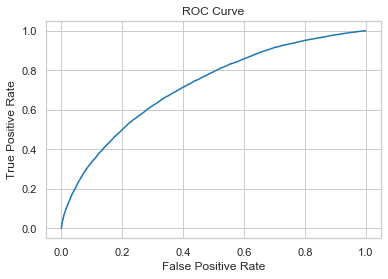

ROC AUC Score: 0.7218977370431503


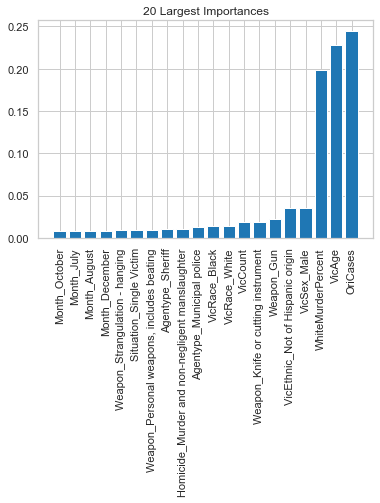

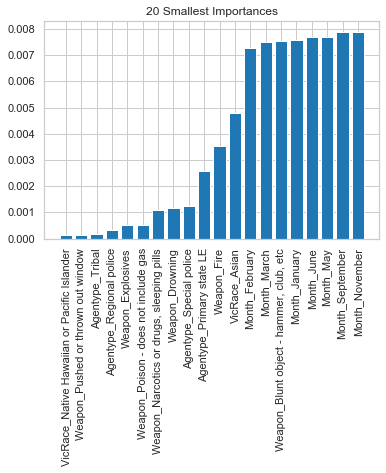

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1  0.000000   0.086444      5
2   0.15  0.111111   0.136423      9
3    0.2  0.147059   0.177807     34
4   0.25  0.132450   0.229412    151
5    0.3  0.135211   0.276666    355
6   0.35  0.162044   0.325371    685
7    0.4  0.189220   0.376582    872
8   0.45  0.202975   0.426951   1143
9    0.5  0.221442   0.477632   1567
10  0.55  0.247889   0.528730   2961
11   0.6  0.352225   0.577374   4517
12  0.65  0.410039   0.626743   5319
13   0.7  0.461194   0.673943   5141
14  0.75  0.525571   0.725295   4595
15   0.8  0.604377   0.775043   5346
16  0.85  0.666809   0.823208   4679
17   0.9  0.760847   0.874227   3918
18  0.95  0.830331   0.922003   2387
19     1  0.925208   0.965232    722


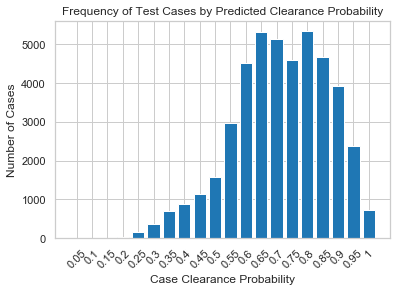

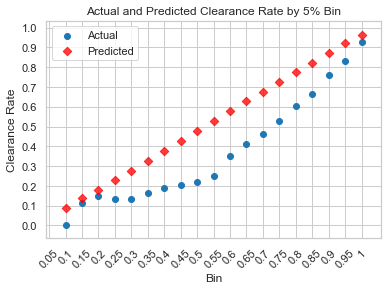

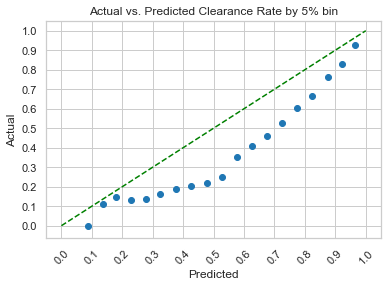

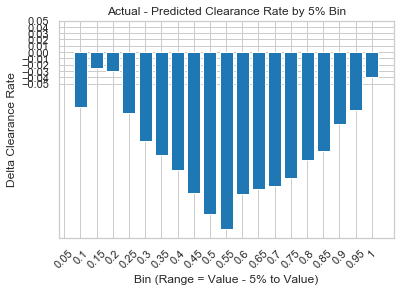

Sum of Squared Binned Residuals: 5541.72245340144
Reporting Time: 3.7 seconds


C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


In [40]:
model  = RandomForestClassifier(n_jobs = 4, 
                            random_state = 33,
                            class_weight = 'balanced',
                            fit_intercept = True,
                            penalty = 'l2',
                            C = 0.01)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_validation_balanced, y_pred, y_pred_prob)

In [25]:
proba_df.head()

,Solved,Predicted Probability,Bin
47824,0,0.301479,0.35
162750,1,0.347048,0.35
2379,0,0.575055,0.6
79265,0,0.528918,0.55
143254,1,0.742040,0.75


In [26]:
results_df = pd.concat([proba_df,
                        df_categorical,
                        df_numerical],
                       axis = 1)
print(results_df.columns)

Index(['Solved', 'Predicted Probability', 'Bin', 'Agentype', 'Month',
       'Homicide', 'Situation', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon',
       'VicAge', 'VicCount', 'OriCases', 'WhiteMurderPercent'],
      dtype='object')


In [27]:
bin_breakdown = results_df.groupby(['Bin','VicRace'])['VicRace'].count()
bin_race_breakdown = bin_breakdown.unstack()
bin_race_breakdown['Total'] = results_df.groupby('Bin')['VicRace'].count()
bin_race_breakdown['Black Percent'] = bin_race_breakdown.Black / bin_race_breakdown.Total
bin_race_breakdown['Native Percent'] = bin_race_breakdown['American Indian or Alaskan Native'] / bin_race_breakdown.Total
bin_race_breakdown['Asian Percent'] = bin_race_breakdown.Asian / bin_race_breakdown.Total
bin_race_breakdown['Native Islander Percent'] = bin_race_breakdown['Native Hawaiian or Pacific Islander'] / bin_race_breakdown.Total
bin_race_breakdown['White Percent'] = bin_race_breakdown.White / bin_race_breakdown.Total
bin_race_breakdown

VicRace,American Indian or Alaskan Native,Asian,Black,Native Hawaiian or Pacific Islander,White,Total,Black Percent,Native Percent,Asian Percent,Native Islander Percent,White Percent
Bin,,,,,,,,,,,
0.05,0,0,4,0,0,4,1.000000,0.000000,0.000000,0.000000,0.000000
0.1,0,0,33,0,52,85,0.388235,0.000000,0.000000,0.000000,0.611765
0.15,0,2,366,0,168,536,0.682836,0.000000,0.003731,0.000000,0.313433
0.2,1,3,864,0,258,1126,0.767318,0.000888,0.002664,0.000000,0.229130
0.25,0,11,908,0,481,1400,0.648571,0.000000,0.007857,0.000000,0.343571
0.3,2,47,1118,0,1055,2222,0.503150,0.000900,0.021152,0.000000,0.474797
0.35,9,61,2070,1,1951,4092,0.505865,0.002199,0.014907,0.000244,0.476784
0.4,7,102,2833,0,2399,5341,0.530425,0.001311,0.019098,0.000000,0.449167
0.45,16,115,2204,0,2726,5061,0.435487,0.003161,0.022723,0.000000,0.538629


<BarContainer object of 20 artists>

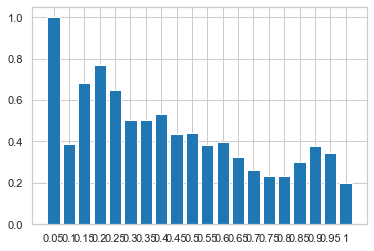

In [28]:
plt.bar(bin_race_breakdown.index, bin_race_breakdown['Black Percent'])

<BarContainer object of 20 artists>

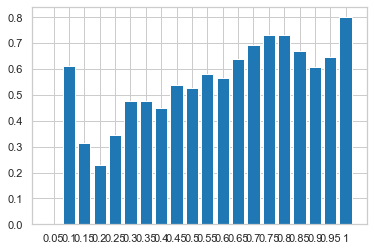

In [29]:
plt.bar(bin_race_breakdown.index, bin_race_breakdown['White Percent'])

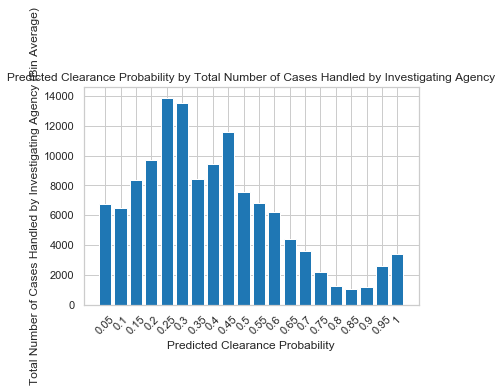

In [30]:
bin_breakdown = results_df.groupby('Bin')['OriCases'].mean()
plt.bar(bin_breakdown.index, bin_breakdown)
plt.xticks(rotation = 45)
plt.title('Predicted Clearance Probability by Total Number of Cases Handled by Investigating Agency')
plt.xlabel('Predicted Clearance Probability')
plt.ylabel('Total Number of Cases Handled by Investigating Agency (Bin Average)')
plt.show()

AWESOME!!!!!

<BarContainer object of 20 artists>

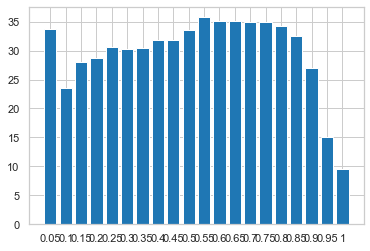

In [31]:
bin_breakdown = results_df.groupby('Bin')['VicAge'].mean()
plt.bar(bin_breakdown.index, bin_breakdown)

<BarContainer object of 20 artists>

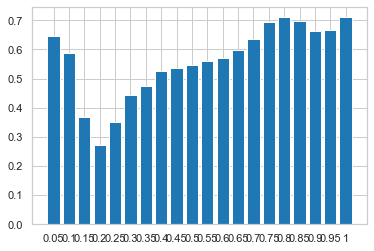

In [32]:
bin_breakdown = results_df.groupby('Bin')['WhiteMurderPercent'].mean()
plt.bar(bin_breakdown.index, bin_breakdown)

In [35]:
bin_breakdown = results_df.groupby(['Bin','VicSex'])['VicSex'].count()
bin_sex_breakdown = bin_breakdown.unstack()
bin_sex_breakdown['Total'] = results_df.groupby('Bin')['VicSex'].count()
bin_sex_breakdown['Male Percent'] = bin_sex_breakdown.Male / bin_sex_breakdown.Total
bin_sex_breakdown['Female Percent'] = bin_sex_breakdown.Female / bin_sex_breakdown.Total
bin_sex_breakdown

VicSex,Female,Male,Total,Male Percent,Female Percent
Bin,,,,,
0.05,0,4,4,1.000000,0.000000
0.1,2,83,85,0.976471,0.023529
0.15,14,522,536,0.973881,0.026119
0.2,51,1075,1126,0.954707,0.045293
0.25,104,1296,1400,0.925714,0.074286
0.3,168,2054,2222,0.924392,0.075608
0.35,234,3858,4092,0.942815,0.057185
0.4,374,4967,5341,0.929976,0.070024
0.45,511,4550,5061,0.899032,0.100968


<BarContainer object of 20 artists>

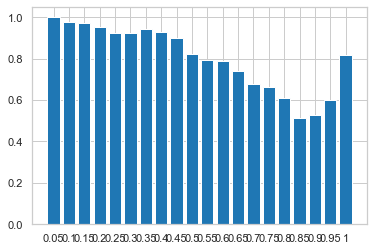

In [38]:
plt.bar(bin_sex_breakdown.index, bin_sex_breakdown['Male Percent'])

Add breakdown of location

Add regression lines

In [9]:
model = LogisticRegression()

In [22]:
#Add multiple scoring!!
#def cross_val_custom_scoring(model, scoring):

start_cross_val = timer()

scores = cross_val_score(model, X_train, y_train, scoring = binned_squared_loss)

print('Scores:', scores)
print('Mean:', round(scores.mean(), 2))
print('Standard Deviation', round(scores.std(), 2))

end_cross_val = timer()
print('Cross Validation Time:', round(end_cross_val - start_cross_val,1), 'seconds')

C:\Users\Classy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
C:\Users\Classy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
C:\Users\Classy\anaconda3\lib\site-package

Scores: [ -478.81520785  -462.17076923  -615.36729123 -8044.48441743
 -7841.71252911]
Mean: -3488.51
Standard Deviation 3638.11
Cross Validation Time: 4.0 seconds


C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


In [ ]:
#train-test a few model types and use custom scoring function and updated output

In [ ]:
#gridsearch best model (likely Random Forest) using custom scoring function

In [39]:
model  = LogisticRegression()

grid = [{'C': [.000000001, .00000001, .0000001, .000001, .00001]}]

scoring = {'f1' : 'f1',
           'accuracy' : 'accuracy',
           'binned squared loss' : binned_squared_loss}

grid_search = GridSearchCV(model, 
                           param_grid = grid, 
                           scoring = scoring, 
                           n_jobs = 3, 
                           verbose = True, 
                           return_train_score = False, 
                           refit = False)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:    3.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid=[{'C': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}],
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring={'accuracy': 'accuracy',
                      'binned squared loss': make_scorer(binned_sum_of_squared_residuals, greater_is_better=False, needs_proba=True),
                      'f1

In [40]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,...,std_test_accuracy,rank_test_accuracy,split0_test_binned squared loss,split1_test_binned squared loss,split2_test_binned squared loss,split3_test_binned squared loss,split4_test_binned squared loss,mean_test_binned squared loss,std_test_binned squared loss,rank_test_binned squared loss
0,0.290134,0.026874,0.058518,0.004246,1e-09,{'C': 1e-09},0.561473,0.564721,0.572477,0.568541,...,0.002140,5,-158.274405,-178.420091,-179.132143,-172.752129,-176.482367,-173.012227,7.694300,4
1,0.310885,0.030446,0.063047,0.004093,1e-08,{'C': 1e-08},0.561473,0.564744,0.572477,0.568541,...,0.002150,4,-158.102790,-178.395828,-178.953055,-172.575624,-176.610265,-172.927512,7.741686,3
2,0.321437,0.029114,0.063089,0.003945,1e-07,{'C': 1e-07},0.561767,0.564236,0.572387,0.568756,...,0.002025,3,-157.811863,-175.736469,-177.059276,-172.007648,-176.303633,-171.783778,7.199281,2
3,0.336754,0.025163,0.058616,0.004228,1e-06,{'C': 1e-06},0.562193,0.564486,0.573393,0.568672,...,0.002266,2,-144.888966,-163.875878,-166.642819,-158.496002,-165.120098,-159.804753,7.947070,1
4,0.343942,0.059157,0.052397,0.008405,1e-05,{'C': 1e-05},0.567077,0.568971,0.577262,0.573049,...,0.001900,1,-1767.270985,-2479.764444,-2532.691853,-1875.967586,-2335.686513,-2198.276276,316.101057,5


In [41]:
pd.DataFrame(grid_search.cv_results_).mean_test_accuracy

0    0.591252
1    0.591275
2    0.591425
3    0.592453
4    0.599059
Name: mean_test_accuracy, dtype: float64

Add some logreg lines to the above charts

Maybe try a smaller number of bins and see what happens

Oh! Try validation on an unbalanced (or at least differently balanced) dataset and see what the results look like